## <p style="text-align: right;"> &#9989; Put your name(s) here</p>

# In-Class Assignment: Principal Component Analysis (PCA)

<img src="http://lazyprogrammer.me/wp-content/uploads/2015/11/PCA.jpg" width="400"><a href="http://lazyprogrammer.me/tutorial-principal-components-analysis-pca//"><p style="text-align: right;">
Image from http://lazyprogrammer.me/
</p></a>

### Agenda for today's class (110 minutes)

</p>

1. (10 minutes) ADDED - Homework 1 Review
1. (30 minutes) ADDED - Introduction to Machine Learning and SVM.
1. (30 minutes) Review of Pre-class assignment
1. (60 minutes) Activity: Feature Selection and PCA
1. (20 minutes) Project Brainstorming


# 1. Review of pre-class assignment

# 2. Activity: Feature Selection and PCA

For each of the following steps; run the code and discuss as a group what the code is doing.  As a class we will continue the discussion. 

## Step A: Download and review the digits dataset

Let's start with downloading a dataset called "digits" which is included in the sklearn library

In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import numpy as np
from sklearn.datasets import fetch_lfw_people, load_digits

sk_data = load_digits();#min_faces_per_person=50, resize=0.4)

In [2]:
from ipywidgets import interact

def browse_images(images, labels, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))

In [3]:
browse_images(sk_data.images, sk_data.target, sk_data.target_names)

interactive(children=(IntSlider(value=898, description='i', max=1796), Output()), _dom_classes=('widget-interact',))

Let's introspect the images arrays to find the shapes (for plotting with matplotlib)

In [4]:
feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names

n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

**Question 1**: Write some code to print out the number of samples, number of features, number of classes, and the shape of the image dimensions:

In [5]:
#PUT your answer to the above question here

**Question 2**: As a group discuss the difference between the features, samples, classes.  How do these relate to the shape of the image?  Write down a quick definition of each:

 <font size=8 color="#009600">&#9998;</font> Do This - Erase this first line of this cell and finish describing variables. Use appropriate markdown to make your answer readable. (double-click on this text to edit this cell, and hit shift+enter to save the text)
 
 
1. **n_samples:** Total number of images in the digits dataset. 
2. **n_features:**
3. **n_classes:**
4. **N:**
5. **h:**
6. **w:**


Let's have a look at the repartition among target classes:

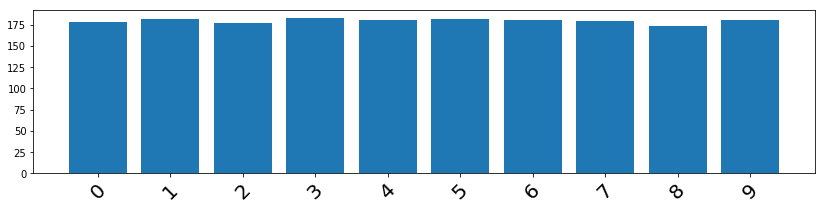

In [6]:
plt.figure(figsize=(14, 3))

y_unique = np.unique(class_labels)
counts = [(class_labels == i).sum() for i in y_unique]

plt.xticks(y_unique,  categories[y_unique])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=20)
_ = plt.bar(y_unique, counts)

## Step B: Splitting the dataset for model development and then evaluation

Let's split the data in a development set and final evaluation set.

In [7]:
from sklearn.cross_validation import train_test_split

train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=0.25)
print(len(train_vectors))
print(len(test_vectors))

1347
450


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


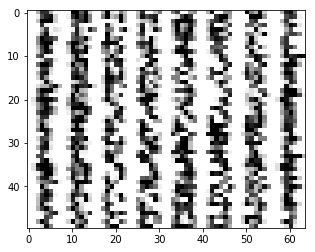

In [8]:
plt.imshow(test_vectors[0:50,:], cmap=plt.cm.gray_r)

(8, 8)

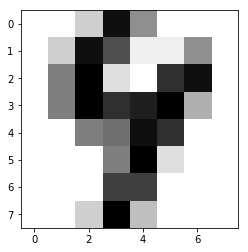

In [9]:
vec = test_vectors[333,:]

im = vec.reshape(8,8)
plt.imshow(im, cmap=plt.cm.gray_r)
im.shape

&#9989; Do This - As a group and then as a class. Discuss why we need to separate our samples into a training and testing set. 

## Step C: Calculate PCA transform and select feature subset. 

To train a model we will first reduce the dimensionality of the original picture to a 4 PCA space. This is often called unsupervised feature extraction.

In [10]:
from sklearn.decomposition import RandomizedPCA

n_components = 4 # This is much less than the original n_features

print("Extracting the top %d eigenfaces from %d faces" % (
    n_components, train_vectors.shape[0]))

pca = RandomizedPCA(n_components=n_components, whiten=True)

%time pca.fit(train_vectors)

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 4 eigenfaces from 1347 faces
CPU times: user 71.4 ms, sys: 26.9 ms, total: 98.3 ms
Wall time: 141 ms


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
pca.components_.shape

(4, 64)

Notice that the length of these new vectors are the same size as the original data. Let's plot the gallery of the most significant eigenfaces:

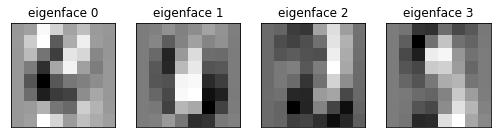

In [12]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray_r)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row=1, n_col=4)

## Step D: transform the training and testing sets into the new feature space

In [13]:
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

train_pca = pca.transform(train_vectors)
test_pca = pca.transform(test_vectors)


print("Training set changed from a size of: ", train_vectors.shape, ' to: ', train_pca.shape)
print("Testing set changed from a size of: ", test_vectors.shape, ' to: ', test_pca.shape)

Training set changed from a size of:  (1347, 64)  to:  (1347, 4)
Testing set changed from a size of:  (450, 64)  to:  (450, 4)


/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Step E: Train an SVM Classifier based on the training dataset.

In [14]:
###############################################################################
# Train a SVM classification model

#make some temporary variablse so you can change this easily
tmp_vectors = train_pca
tmp_labels = train_labels

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(tmp_vectors, tmp_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Step F: Show the results of the classification on the testing dataset.

In [15]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

#make some temporary variablse so you can change this easily
predict_vectors = test_pca
true_lables = test_labels

print("Predicting people's names on the test set")
pred_labels = clf.predict(predict_vectors)

print(classification_report(true_lables, pred_labels))
print(confusion_matrix(true_lables, pred_labels, labels=range(n_classes)))


Predicting people's names on the test set
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        47
          1       0.84      0.91      0.87        45
          2       0.94      0.79      0.86        39
          3       0.85      0.74      0.80        47
          4       0.98      0.94      0.96        47
          5       0.85      0.71      0.77        48
          6       1.00      1.00      1.00        51
          7       0.70      0.91      0.79        44
          8       0.69      0.79      0.73        42
          9       0.72      0.72      0.73        40

avg / total       0.86      0.85      0.85       450

[[46  0  0  0  0  1  0  0  0  0]
 [ 0 41  0  0  0  0  0  3  1  0]
 [ 0  3 31  2  0  1  0  0  2  0]
 [ 0  0  1 35  0  0  0  2  3  6]
 [ 0  0  0  0 44  0  0  3  0  0]
 [ 0  0  0  1  1 34  0  1  7  4]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  2  0  0  0  0  0 40  1  1]
 [ 0  2  1  0  0  3  0  3 33  0]
 [ 0  1  0  3  0  1  0

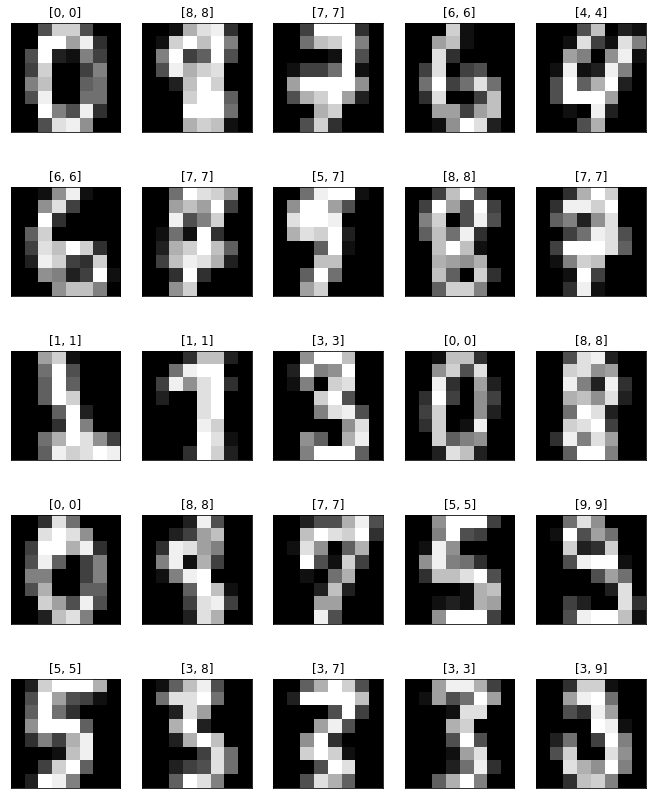

In [16]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title([true_titles[i],pred_titles[i]], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(test_vectors, test_labels, pred_labels, h,w)

** Question 3: ** What is the overall precision of the algorithm When selecting 4 eigenvectors. 

<font size=8 color="#009600">&#9998;</font> Do This - Erase the contents of this cell and replace it with your answer to the above question!  (double-click on this text to edit this cell, and hit shift+enter to save the text)

** Question 4: ** What is the overall precision of the algorithm When selecting 40 eigenvectors? 64?

<font size=8 color="#009600">&#9998;</font> Do This - Erase the contents of this cell and replace it with your answer to the above question!  (double-click on this text to edit this cell, and hit shift+enter to save the text)

** Question 5: ** Play around with the training set in Steps **E** and **F**.  What happens to the overall precision if you train with the original train_vector and test with the original test_vector (instead of the train_pca and test_pca features vectors).  

<font size=8 color="#009600">&#9998;</font> Do This - Erase the contents of this cell and replace it with your answer to the above question!  (double-click on this text to edit this cell, and hit shift+enter to save the text)

# Step 3: Homework 2

 As a class lets download and review the second homework.

 # Step 4: Project Brainstorming
 
 As a group and then as a class. Brainstorm some ideas for appropriate class projects.  Use this discussion as a way to communicate to your instructors what kinds of problems do you want to solve. Some things we want to include in the projects:
 
 * Scientific Domain
 * Can be easily broken down and shared by group members.
 * Uses some dataset or python module that needs to be imported into jupyter. 

** Question 6: ** What are some of your favorite ideas? 

<font size=8 color="#009600">&#9998;</font> Do This - Erase the contents of this cell and replace it with your answer to the above question!  (double-click on this text to edit this cell, and hit shift+enter to save the text)

---------
### Congratulations, you're done with your in-class assignment!

Now, you just need to submit this assignment by uploading it to the course Desire2Learn web page (Don't forget to add your names in the first cell).  Go to the "in-class assignments" folder, find the dropbox link for "05-PCA", and upload it there.

&#169; Copyright 2016,  Michigan State University Board of Trustees